# Identifying Customer Segments with K-Means Clustering

In this project, I'm analyzing a dataset containing data on a company's online retail transactions. The dataset for this notebook can be found at [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/online+retail).



In [3]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Show matplotlib plots inline
%matplotlib inline

In [4]:
# Import retail dataset into pandas dataframe
df = pd.read_csv('/content/Online-retail.csv')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Dataset Attribute Information:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.

# Data Preparation

Before building our K-Means clustering models, we need to clean our data:
- Drop cancelled orders
- Drop records with missing CustomerID
- Exclude incomplete months
- Determine Total Sales from the Quantity and UnitPrice columns



In [5]:
customer_country=df[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


In [6]:
# Drop cancelled orders
df = df.loc[df['Quantity'] > 0]

# Drop records with missing Customer ID
df = df[pd.notnull(df['CustomerID'])]

# Drop incomplete month
df = df.loc[df['InvoiceDate'] < '2011-12-01']

# Calculate total sales from the Quantity and UnitPrice
df['Sales'] = df['Quantity'] * df['UnitPrice']

Generate new DataFrame with only TotalSales, the OrderCount, and the AvgOrderValue for each customer:

In [7]:
# use groupby to aggregate sales by CustomerID
customer_df = df.groupby('CustomerID').agg({'Sales': sum,
                                            'InvoiceNo': lambda x: x.nunique()})

# Select the columns we want to use
customer_df.columns = ['TotalSales', 'OrderCount']

# create a new column 'AvgOrderValu'
customer_df['AvgOrderValue'] = customer_df['TotalSales'] / customer_df['OrderCount']

customer_df.head(20)

<ipython-input-7-8d7f3b3f34c6>:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  customer_df = df.groupby('CustomerID').agg({'Sales': sum,


,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,2706.32,4,676.580000
12348.0,1120.24,2,560.120000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000
12352.0,608.23,2,304.115000
12356.0,2329.97,2,1164.985000
12357.0,6207.67,1,6207.670000
12358.0,683.20,1,683.200000


# Normalize data before clustering

In [8]:
ranked_df = customer_df.rank(method='first')
ranked_df.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,3248.0,1.0,3250.0
12347.0,3005.0,2601.0,2909.0
12348.0,2475.0,1531.0,2763.0
12349.0,2797.0,2.0,3200.0
12350.0,1152.0,3.0,1969.0


In [9]:
# Center values around 0 with standard deviation of 1
ranked_df = customer_df.rank(method='first')
normalized_df = (ranked_df - ranked_df.mean()) / ranked_df.std()
normalized_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.728056,-1.731252,1.730186
12347.0,1.469167,1.038751,1.366890
12348.0,0.904512,-0.101212,1.211344
12349.0,1.247567,-1.730186,1.676917
12350.0,-0.504993,-1.729121,0.365427
12352.0,0.250366,-0.100146,0.099081
12356.0,1.403113,-0.099081,1.612994
12357.0,1.649217,-1.728056,1.728056
12358.0,0.398454,-1.726990,1.378609


In [10]:
normalized_df.describe()

,TotalSales,OrderCount,AvgOrderValue
count,3.251000e+03,3.251000e+03,3.251000e+03
mean,-4.371226e-18,1.748490e-17,-1.748490e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.731252e+00,-1.731252e+00,-1.731252e+00
25%,-8.656259e-01,-8.656259e-01,-8.656259e-01
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.656259e-01,8.656259e-01,8.656259e-01
max,1.731252e+00,1.731252e+00,1.731252e+00


## Select the optimal number of clusters with the Elbow Method

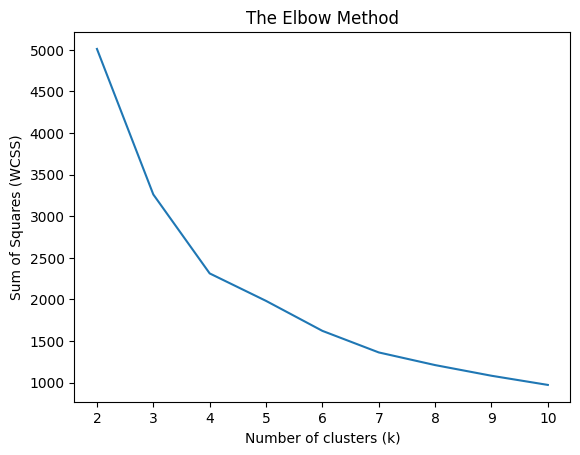

In [11]:
# Use the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans

wcss = []
krange = list(range(2,11))
X = normalized_df[['TotalSales','OrderCount','AvgOrderValue']].values
for n in krange:
    model = KMeans(n_clusters=n, random_state=3)
    model.fit_predict(X)
    # Store labels of clusters in label_ attribute of kmeans model object
    cluster_assignments = model.labels_
    # Store cluster centers of clusters in cluster_center_ attribute of kmeans model object
    centers = model.cluster_centers_
    wcss.append(np.sum((X - centers[cluster_assignments]) ** 2))

plt.plot(krange, wcss)
plt.title('The Elbow Method')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of Squares (WCSS)")
plt.show()

Based on the above elbow method, we get 4 as the number of optimum clusters and thus we may take k as 4 for the KMeans model

### K-Means Clustering

In [14]:
kmeans = KMeans(n_clusters=4).fit(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])

four_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)

# Store labels of clusters in labels_ attribute of the kmeans model object
four_cluster_df['Cluster'] = model.labels_

four_cluster_df.head(10)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.728056,-1.731252,1.730186,2
12347.0,1.469167,1.038751,1.366890,1
12348.0,0.904512,-0.101212,1.211344,1
12349.0,1.247567,-1.730186,1.676917,2
12350.0,-0.504993,-1.729121,0.365427,2
12352.0,0.250366,-0.100146,0.099081,3
12356.0,1.403113,-0.099081,1.612994,1
12357.0,1.649217,-1.728056,1.728056,2
12358.0,0.398454,-1.726990,1.378609,2


In [15]:
cluster1_metrics = kmeans.cluster_centers_[0]
cluster2_metrics = kmeans.cluster_centers_[1]
cluster3_metrics = kmeans.cluster_centers_[2]
cluster4_metrics = kmeans.cluster_centers_[3]

data = [cluster1_metrics, cluster2_metrics, cluster3_metrics, cluster4_metrics]
cluster_center_df = pd.DataFrame(data)

cluster_center_df.columns = four_cluster_df.columns[0:3]
cluster_center_df

,TotalSales,OrderCount,AvgOrderValue
0,-0.043459,-0.936800,0.816818
1,1.200327,0.951259,0.929960
2,0.226295,0.769026,-0.579053
3,-1.243190,-0.724496,-1.043315


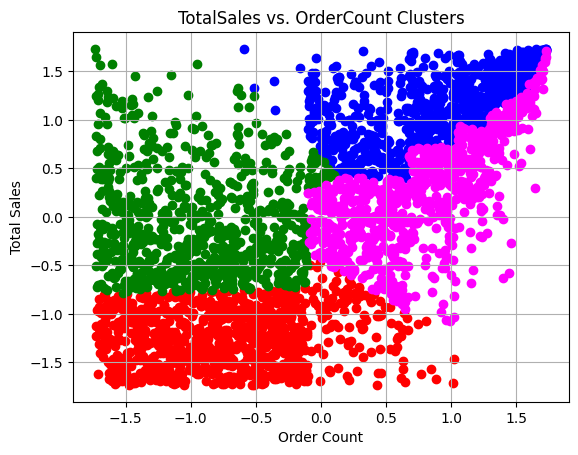

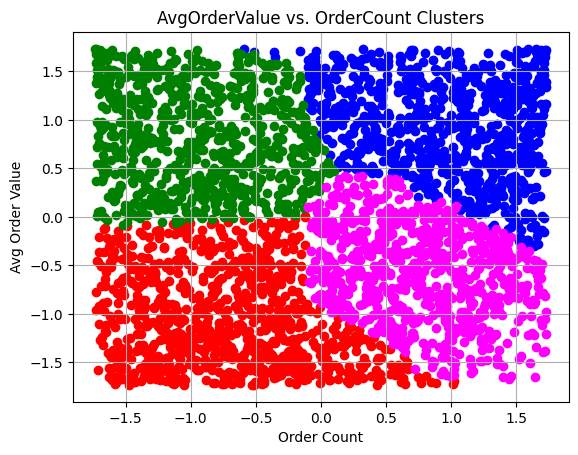

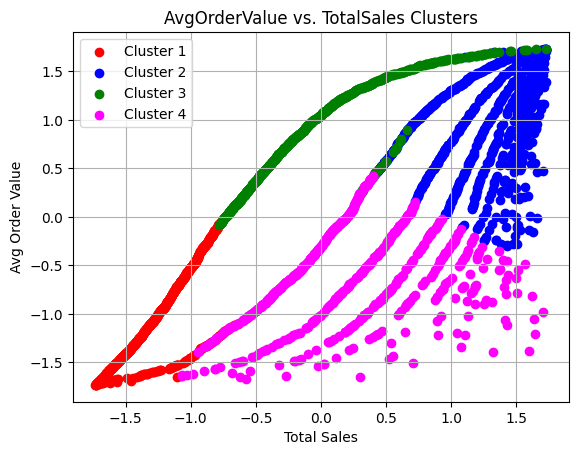

In [16]:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
    c='red', label='Cluster 1')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
    c='blue', label='Cluster 2')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
    c='green', label='Cluster 3')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
    c='magenta', label='Cluster 4')

plt.title('TotalSales vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')
# plt.legend()
plt.grid()
plt.show()


plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='red', label='Cluster 1')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='blue', label='Cluster 2')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='green', label='Cluster 3')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='magenta', label='Cluster 4')

plt.title('AvgOrderValue vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')
# plt.legend()
plt.grid()
plt.show()


plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='red', label='Cluster 1')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='blue', label='Cluster 2')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='green', label='Cluster 3')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='magenta', label='Cluster 4')

plt.title('AvgOrderValue vs. TotalSales Clusters')
plt.xlabel('Total Sales')
plt.ylabel('Avg Order Value')
plt.legend()
plt.grid()
plt.show()

As we saw above, we built a clustering model that split the data into 4 custmer segments, based on the TotalSales, AvgOrderValues, and OrderCount values.

## Determine best-selling items for each customer segment

In [17]:
high_val_cluster = four_cluster_df.loc[four_cluster_df['Cluster'] == 2]

pd.DataFrame(df.loc[df['CustomerID'].isin(high_val_cluster.index)].groupby(
    'Description').count()['StockCode'].sort_values(ascending=False).head())


,StockCode
Description,
REGENCY CAKESTAND 3 TIER,104
WHITE HANGING HEART T-LIGHT HOLDER,96
POSTAGE,89
PAPER CHAIN KIT 50'S CHRISTMAS,88
SET OF 3 CAKE TINS PANTRY DESIGN,83


# Next Steps